In [204]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import wandb
import os
import time

In [205]:
wandb.login()

True

MPS is available


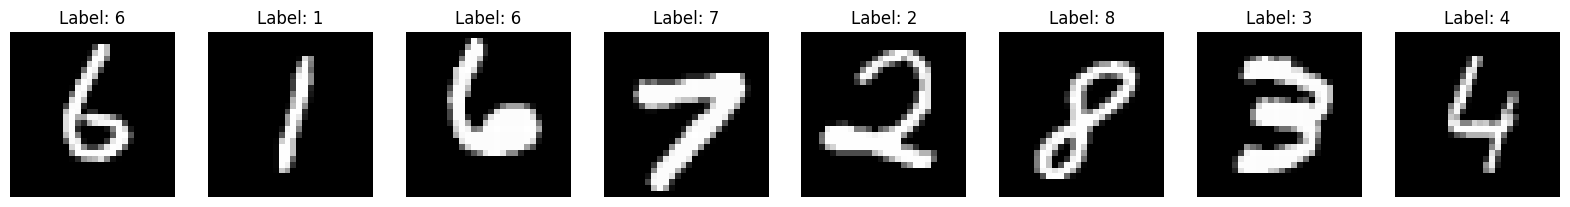

In [206]:
# hyper parameters
EPOCHS = 500
LEARNING_RATE = 1e-4
IMAGE_SIZE = 28
IMAGE_CHANNELS = 1
NUM_LABELS = 10
BATCH_SIZE = 64
TIMESTEPS = 500
device = torch.device("mps" if torch.mps.is_available() else "cpu")

if torch.device('mps').type == "mps" and torch.backends.mps.is_available():
    print("MPS is available")
else:
    print("MPS is not available")
    
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

mnist = datasets.MNIST(root="./data", download=True, transform=transform, train=True)
data_loader = DataLoader(mnist, batch_size=BATCH_SIZE, shuffle=True)

# Visualize a batch
def visualize_images(data_loader):
    """Visualize a batch of grayscale images (MNIST)."""
    for images, labels in data_loader:
        fig, axes = plt.subplots(1, 8, figsize=(20, 5))  # Display 8 images

        for i in range(8):
            img = images[i].detach().cpu().squeeze(0).numpy()  # Remove channel dim (1, H, W) → (H, W)
            axes[i].imshow(img, cmap="gray")  # Force grayscale display
            axes[i].set_title(f"Label: {labels[i].item()}")
            axes[i].axis("off")

        plt.show()
        break 

# Example usage
visualize_images(data_loader)

In [207]:
def get_sin_beta_schedule(start=0.0001, end=0.02, timesteps=TIMESTEPS, device="cpu"):
    t = torch.linspace(0, torch.pi, timesteps, device=device)  # Phase from 0 to π
    beta = start + (end - start) * (0.5 * (1 - torch.cos(t)))  # Smooth transition from start to end
    return beta

# Precompute alpha values
def compute_alphas(device=device):
    alphas = 1.0 - get_sin_beta_schedule(device=device)
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    return alphas_cumprod

# Forward process: Add noise to image
def forward_diffusion_sample(images, timestamp, device=device):
    batch_size, _, _, _ = images.shape
    noise = torch.randn_like(images, device=device)
    alphas_cumprod = compute_alphas(device=device)
    sqrt_alpha_t = torch.sqrt(alphas_cumprod[timestamp]).view(batch_size, 1, 1, 1)
    sqrt_one_minus_alpha_t = torch.sqrt(1 - alphas_cumprod[timestamp]).view(batch_size, 1, 1, 1)
    return sqrt_alpha_t * images + sqrt_one_minus_alpha_t * noise, noise

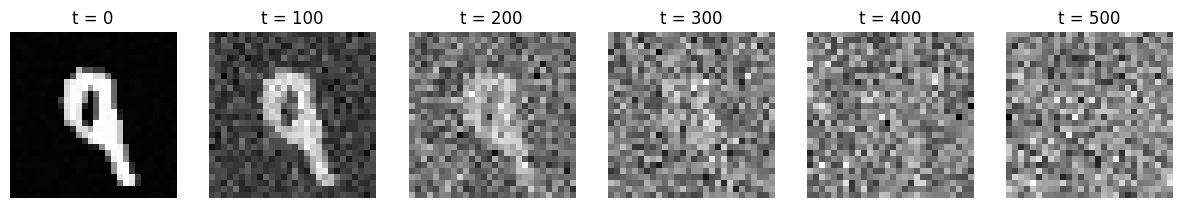

In [208]:
# Get a sample image
image, _ = next(iter(data_loader))
image = image[:1]  # Only one image

noisy_images = []
for t in [0, 100, 200, 300, 400, 499]:  # Select specific timesteps
    noisy_image, _ = forward_diffusion_sample(image, t, device="cpu")
    noisy_images.append(noisy_image)

# Plot results
fig, axes = plt.subplots(1, len(noisy_images), figsize=(15, 5))
for i, img in enumerate(noisy_images):
    axes[i].imshow(img[0].detach().cpu().squeeze(0).numpy(), cmap="gray")  # Rescale for display
    axes[i].set_title(f"t = {i * 100}")
    axes[i].axis('off')
plt.show()

In [209]:
class EncodeBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        
        # convert time_emb to the correct number of channels for this block
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        
        # scale features x 2, then refine
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)            
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

        # normalize
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        
        # halve resolution
        self.downres = nn.MaxPool2d(kernel_size=2)

    def forward(self, x, t):
        # First convolution + batch norm + activation
        x = self.relu(self.bnorm1(self.conv1(x)))

        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb.unsqueeze(2).unsqueeze(3)  # Reshape for broadcasting

        # Add time embedding to feature map
        x = x + time_emb

        # Second convolution + batch norm + activation
        x_pre_downres = self.relu(self.bnorm2(self.conv2(x)))
        
        # Upsample or Downsample
        return self.downres(x_pre_downres), x_pre_downres  # return output and output before reshaping for skip

In [210]:
class BottleNeck(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        
        # convert time_emb to the correct number of channels for this block
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        
        # scale features x 2, then refine
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)            
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

        # normalize
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x, t):
        # First convolution + batch norm + activation
        x = self.relu(self.bnorm1(self.conv1(x)))

        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb.unsqueeze(2).unsqueeze(3)  # Reshape for broadcasting

        # Add time embedding to feature map
        x = x + time_emb

        # Second convolution + batch norm + activation
        x = self.relu(self.bnorm2(self.conv2(x)))
        
        return x

In [211]:
class DecodeBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        
        # convert time_emb to the correct number of channels for this block
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        
        # Upres 2x for decode layers
        self.upres = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        
        # Input has been concatenated with skip connection (input * 2 is the size)
        self.conv1 = nn.Conv2d(2*out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

        # normalize
        self.bnormUp = nn.BatchNorm2d(out_channels)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x, t, x_skip):
        # scale up + batch norm + activation
        x = self.relu(self.bnormUp(self.upres(x)))
        
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb.unsqueeze(2).unsqueeze(3)  # Reshape for broadcasting
        
        # print("Decode forward:\ntime_emb:", time_emb.shape)  # Should be (batch_size, 128, 14, 14)
        # print("x:", x.shape)  # Should be (batch_size, 128, 14, 14)
        
        # Add time embedding to feature map
        x = x + time_emb
        
        # print("x shape after upres:", x.shape)  # Should be (batch_size, 128, 14, 14)
        # print("x_skip shape:", x_skip.shape)  # Should be (batch_size, 128, 14, 14)
        # print("\n\n")
        
        # concatenate the skip layer
        x = torch.cat((x, x_skip), dim=1)

        # Two convolutions w/ batch norm + activation
        x = self.relu(self.bnorm1(self.conv1(x)))
        x = self.relu(self.bnorm2(self.conv2(x)))

        return x

In [212]:
class SinPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
    def forward(self, time):
        device = time.device
        time = time.float()
        half_dim = self.dim // 2
        embeddings = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [213]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.image_channels = IMAGE_CHANNELS
        self.time_emb_dim = 32
        self.label_emb_dim = 32
        self.bottle_neck_size = [128, 256]
        
        # Time embedding
        self.time_emb = nn.Sequential(
            SinPositionEmbeddings(self.time_emb_dim),
            nn.Linear(self.time_emb_dim, self.time_emb_dim),
            nn.ReLU()
        )
        self.time_emb_scaled = nn.Linear(self.time_emb_dim, self.bottle_neck_size[0])
        
        # Class embedding
        self.label_emb = nn.Embedding(NUM_LABELS, self.label_emb_dim)
        
        # Encode
        self.enc_blocks = nn.ModuleList([EncodeBlock(1, 64, self.time_emb_dim),
                                         EncodeBlock(64, 128, self.time_emb_dim)
                                         ])
        
        # Bottleneck
        self.bottleneck_block = BottleNeck(self.bottle_neck_size[0], self.bottle_neck_size[1], self.time_emb_dim)
        
        # Decode
        self.dec_blocks = nn.ModuleList([DecodeBlock(256, 128, self.time_emb_dim),
                                         DecodeBlock(128, 64, self.time_emb_dim)
                                         ])
        
        # Output
        self.final_conv = nn.Conv2d(64, self.image_channels, kernel_size=3, stride=1, padding=1)
        
    def forward(self, x, timestep, label):
        # Embed time and class and combine
        t_and_c = self.time_emb(timestep) + self.label_emb(label)
        
        # Save skip layers
        saved_outputs = []

        # Encode
        for enc_block in self.enc_blocks:
            x, x_pre_trans = enc_block(x, t_and_c)
            saved_outputs.append(x_pre_trans)
            
        # Bottleneck
        x = self.bottleneck_block(x, t_and_c)
        
        # Decode     
        for dec_block in self.dec_blocks:
            x = dec_block(x, t_and_c, saved_outputs[-1])
            saved_outputs.pop()
            
        return self.final_conv(x)

In [214]:
def get_loss(model, x_0, t, labels):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t, labels)
    return torch.nn.functional.mse_loss(noise_pred, noise)

In [215]:
def denormalize(image):
    """Convert an image from range [-1,1] to [0,1] for proper visualization."""
    return (image + 1) / 2  # Scale values from [-1,1] to [0,1]

In [216]:
def test():
    with torch.no_grad():
        model.eval()
        
        shape = (NUM_LABELS, IMAGE_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
        x = torch.randn(shape, device=device)  # Shape: (10, 1, 28, 28)
    
        betas = get_sin_beta_schedule(device=device)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        
        # Assign each image a unique class label (0-9)
        class_labels = torch.arange(NUM_LABELS, dtype=torch.long, device=device)  # Shape: (10,)

        for t in reversed(range(TIMESTEPS)):
            t_tensor = torch.full((NUM_LABELS,), t, device=device, dtype=torch.long)  # Same t for all samples
            noise_pred = model(x, t_tensor, class_labels)  # Forward all 10 digits at once

            alpha_t = alphas[t]
            alpha_cum_t = alphas_cumprod[t]
            beta_t = betas[t]

            x = (1.0 / torch.sqrt(alpha_t)) * (x - (beta_t / torch.sqrt(1.0 - alpha_cum_t)) * noise_pred)

            if t > 0:                
                sigma_t = torch.sqrt(beta_t)
                noise = torch.randn_like(x)
                x += sigma_t * noise  # Add noise for variance

    return x  # Final batch of 10 generated images (shape: [10, 1, 28, 28])
        

In [217]:
def log(epoch, epoch_loss, test_images):

    # Compute average loss
    epoch_loss /= len(data_loader)

    # Convert test images to W&B format
    wandb_images = [wandb.Image(img.detach().squeeze(0).cpu().numpy(), caption=f"Epoch {epoch+1}") for img in test_images]
    
    # Log to W&B
    wandb.log({
        "epoch_loss": epoch_loss,
        "epoch": epoch + 1,
        "test_images": wandb_images
    })

In [218]:
def display_images(images):
    """Display a list of PyTorch tensors as images in a row, assuming shape (C, H, W)."""

    # Convert tensors to NumPy arrays
    processed_images = []
    for img in images:
        img = img.detach().cpu()  # Move to CPU and detach from computation graph

        if img.shape[0] == 1:  # Grayscale (1, H, W) → (H, W)
            img = img.squeeze(0)  # Remove the channel dimension
        else:  # RGB (3, H, W) → (H, W, 3)
            img = img.permute(1, 2, 0)  # Change from (C, H, W) → (H, W, C)
        
        img = denormalize(img)
        processed_images.append(img.numpy())

    # Create figure
    fig, axes = plt.subplots(1, len(processed_images), figsize=(len(processed_images) * 2, 2))

    if len(processed_images) == 1:
        axes = [axes]  # Ensure axes is iterable when only one image is displayed

    # Display images
    for i, (ax, img) in enumerate(zip(axes, processed_images)):
        ax.imshow(img, cmap="gray" if img.ndim == 2 else None)  # Auto-detect grayscale vs. RGB
        ax.set_title(f"{i}")
        ax.axis("off")  # Hide axes

    plt.show()

In [219]:
def create_save_directory():
    
    # Generate a timestamped filename
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # e.g., "20240205-153045"
    save_dir = f"MNIST_Diffusion_{timestamp}"
    
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    return save_dir

def save_checkpoint(epoch, model, optimizer, save_path):
    
    # save checkpoint
    checkpoint_path = os.path.join(save_path, f"epoch_{epoch}.pth")
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, checkpoint_path)
    
    # save latest (will overwrite every epoch)
    latest_path = os.path.join(save_path, "latest.pth")
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, latest_path)

    print(f"Checkpoint saved: {checkpoint_path}")


In [220]:
def init_wandb(run_name):
    wandb.init(project="MNIST_UNet_Diffusion",
               name=run_name,
               config={
                   "learning_rate": LEARNING_RATE,
                   "epochs": EPOCHS,
                   "batch_size": BATCH_SIZE,
               })

In [221]:
def train():
    
    model.train()
    total_loss = 0
    
    for batch_idx, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = images.size(0)
        
        optimizer.zero_grad()

        # Sample random timesteps for this batch
        t = torch.randint(low=0, high=TIMESTEPS, size=(batch_size,), device=device).long()

        # Compute the loss
        loss = get_loss(model, images, t, labels)

        # Backpropagation
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    return total_loss

In [222]:
# Initialize model, optimizer, and parameters
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
model.train()
save_directory = create_save_directory()
init_wandb(save_directory)

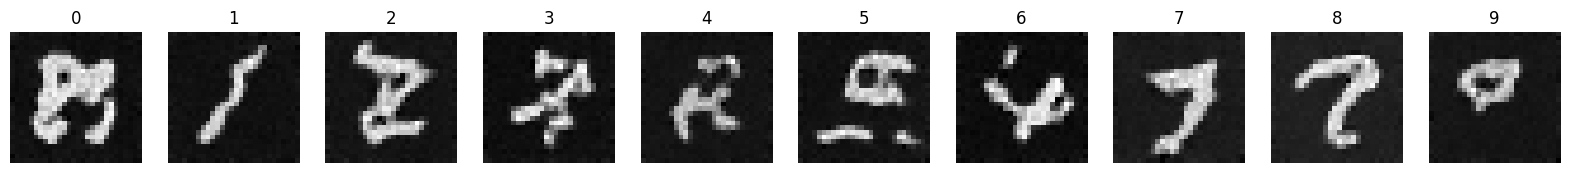

Epoch 1/500, Loss: 122.4712
Checkpoint saved: MNIST_Diffusion_20250205-221325/epoch_0.pth


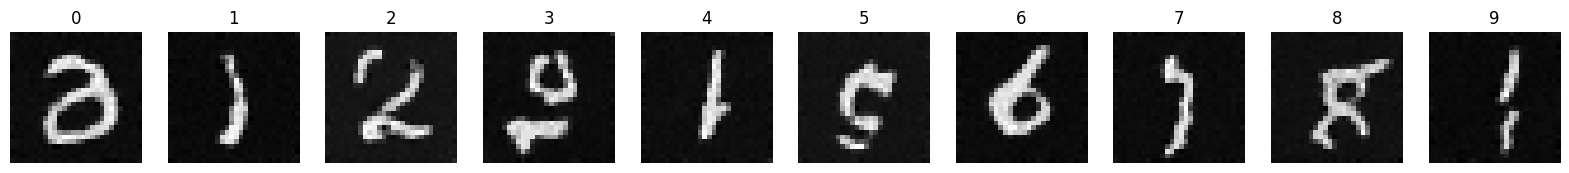

Epoch 2/500, Loss: 71.0691


In [ ]:
# Training loop
try:
    for epoch in range(EPOCHS):
        
        epoch_loss = train()
        test_images = test()
        display_images(test_images)
        log(epoch, epoch_loss, test_images)
        
        print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {epoch_loss:.4f}")
        
        if epoch % 10 == 0:
            save_checkpoint(epoch, model, optimizer, save_directory)
finally:
    wandb.finish()     